# The Quest for Virality: A Linear Regression Model for Predicting the Popularity of Online News


A DSCI-100 Group Project by:
- Manas Mridul (74732843)
- Dylan De Lancie
- Braden Sunderland



## 1. Project Introduction & Research Question

Many eager writers and news publications around the world yearn to determine what makes an online article go viral. Therefore, we formulate our research question as this: **Can we use a linear regression model to reliably predict the popularity of an article, given we know certain features such as those about its written content (eg. word count), embedded digital media (eg. number of images/videos included in article), its sentiment (eg. positive vs. negative word count) and category of publication?**

In this project, we will look at the Online News Popularity dataset which contains 61 characteristics for each of the 39,644 articles published on Mashable.com, along with the number of times the article was shared in social networks (eg. Facebook, Twitter etc.).

Over the course of this report, we will read and wrangle the dataset, conduct some exploratory analyses and attempt to find our best choice of predictors (less than 5). We'll then test our linear regression model, interpret the results and evaluate the observations in light of our research question.

### 1.A. Dataset Information

- The dataset can be accessed here: https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity . There are 61 attributes, 58 predictive, 2 non-predictive, and 1 target variable (shares)  recorded about each observation.
- The target variable in the dataset is the entitled ‘shares’ (data type is double) which is simply the number of times the corresponding article was shared by readers on social networks.

## 2. Setup and Reading Data

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6) 

library("gridExtra") # access to grid.arrange fn, to display plots side by side.
library(GGally) #gives access to the ggpairs() function
library(knitr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### 2.A Loading the dataset and wrangling the data

In [3]:
myFile <- "https://raw.githubusercontent.com/mmanas8/Game-results-for-Top-500-Players-2017-19-Dataset/master/online-news-popularity.csv" #ignore repository name
news_data <- read_csv(myFile)
#head(news_data, 4)
nrow(news_data) #to answer how big is our dataset?

#Combine the multiple vectors relating to data_channel into a single vector using mutate. We argue that this will make things easier both when we create visual plots and 
# and when we create 'dummy variables' to use these categorical variables for linear regression.
tidy_news <- news_data %>%
          mutate(data_channel = ifelse(data_channel_is_lifestyle == 1, "Lifestyle",
                    ifelse(data_channel_is_entertainment == 1, "Entertainment",
                    ifelse(data_channel_is_bus == 1, "Business",
                    ifelse(data_channel_is_socmed == 1, "Social Media", 
                    ifelse(data_channel_is_tech == 1, "Technology",
                    ifelse(data_channel_is_world == 1, "World", "Other"))))))) %>%
#Combine the multiple vectors relating to weekday into a single vector using mutate.
                 mutate(day_of_week = ifelse(weekday_is_monday == 1, "Monday",
                    ifelse(weekday_is_tuesday == 1, "Tuesday",
                    ifelse(weekday_is_wednesday == 1, "Wednesday",
                    ifelse(weekday_is_thursday == 1, "Thursday", 
                    ifelse(weekday_is_friday == 1, "Friday",
                    ifelse(weekday_is_saturday == 1, "Saturday",
                    ifelse(weekday_is_sunday == 1, "Sunday", "N/A")))))))) %>%

                 select(!(contains("is_"))) #only deselects the weekday, data channel vectors made redundant by the code above
                
#colnames(news_data)
tail(tidy_news, 2)
#colnames(tidy_news)

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



[1] 39644

url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,⋯,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel,day_of_week
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
http://mashable.com/2014/12/27/ukraine-blasts/,8,6,682,0.5394933,1,0.6926605,10,1,1,⋯,-0.2052455,-0.5,-0.0125,0.0000000,0.00,0.5000000,0.00,1100,World,Wednesday
http://mashable.com/2014/12/27/youtube-channels-2015/,8,10,157,0.7019868,1,0.8461538,1,1,0,⋯,-0.2000000,-0.2,-0.2000,0.3333333,0.25,0.1666667,0.25,1300,Entertainment,Wednesday


## 3. Creating train/validate data splits
Performing EDAs solely on training set will help us better evaluate the decisions made (such as choosing certain predictors etc) based on the results of EDA and visualizations. The idea behind choosing a train/test split ratio is that there's a tradeoff to be made between training an accurate model (by giving it access to as possibly large training data set) versus ensuring reasonable checks against its performance by using a larger test data set. 

We understand that there's not one universally 'best' split percentage. Since our dataset is fairly big (39,644 observations), we reckon a 75(train)/25(validation) split would be appropriate, while obviously allocating a larger proportion of the dataset for training purposes.   

In [4]:
#Creating data splits
set.seed(4820) # initial_split uses random sampling to choose which rows will be in the training set. We want our code to be reproducible and generate the same train/test split
               # each time it is run. Therefore, we use set.seed. The number 4820 is just a personal choice.

news_split <- initial_split(tidy_news, prop = 0.75, strata = shares)
news_train <- training(news_split)
news_test <- testing(news_split)

## 4. Exploratory Data Analysis using `news_train`

timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,⋯,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
353.5906,10.40395,545.4542,0.5539318,1.004877,0.6943967,10.87973,3.304197,4.532757,1.265151,⋯,0.09541162,0.7570212,-0.259177,-0.5206233,-0.1072771,0.2828655,0.07180543,0.3417356,0.156464,3394.924




Table: 3.A: Quantitative Summary for target variable ie.`shares`

| Maximum| Median| Minimum| Standard Deviation|
|-------:|------:|-------:|------------------:|
|  843300|   1400|       1|           11809.86|

Warning message:
“Removed 150 rows containing non-finite values (stat_density).”


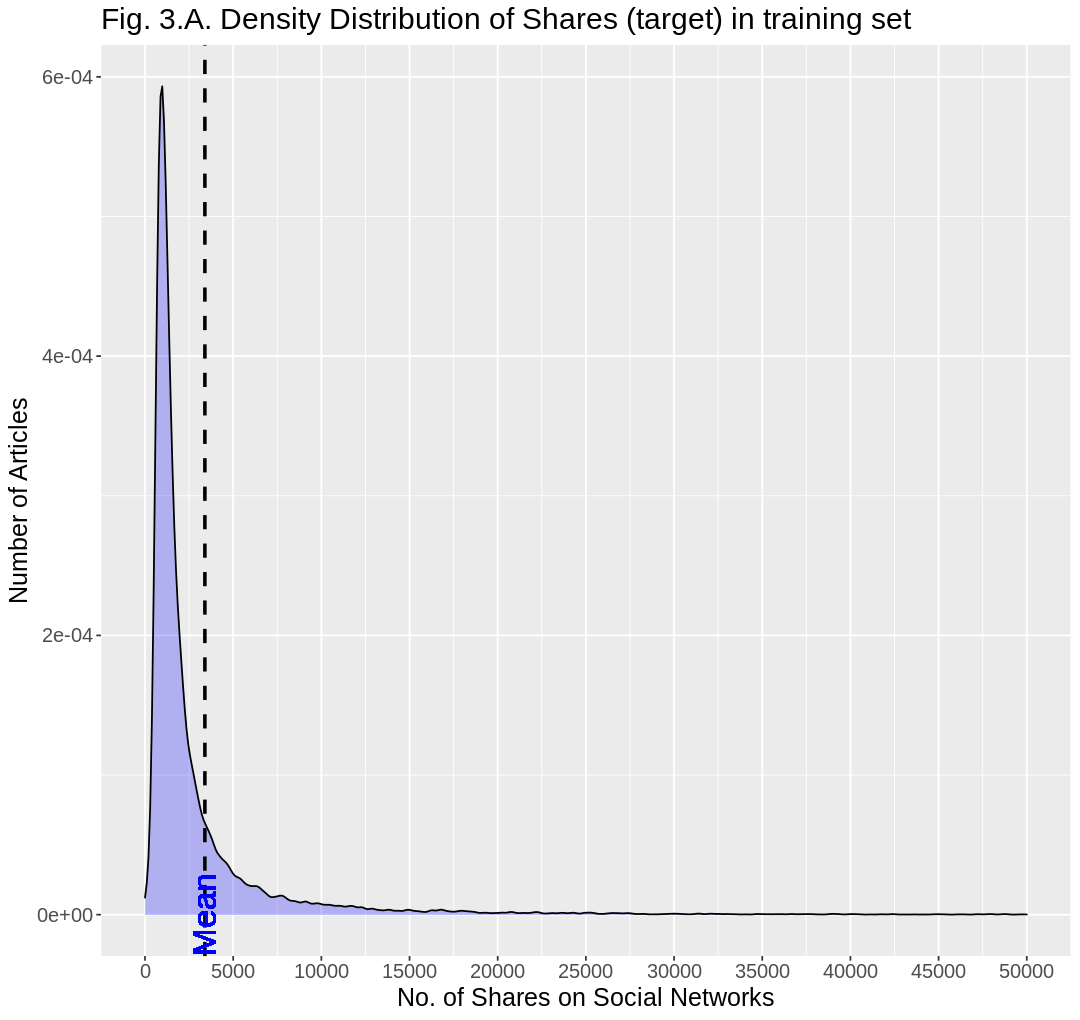

In [5]:
#Means of predictors in train
means_train <- news_train %>%
               select(where(is.numeric)) %>%
               map_df(mean, na.rm = TRUE)

means_train # Very rudimentary, though valuable to know that mean number of shares is 3394.924

#Some more insights about our target variable:
shares_info <- news_train %>%
               summarise(max_shares = max(shares),
                        median_shares = median(shares),
                        min_shares = min(shares),
                        sd_shares = sd(shares))

knitr::kable(shares_info, caption = "3.A: Quantitative Summary for target variable ie.`shares`", col.names = c("Maximum", "Median", "Minimum", "Standard Deviation")) 
#We now know that the range of shares is fairly big, and the number of shares are highly spread out away from the mean (high standard deviation).

#We might benefit from a visualization of the distribution of shares in training set: 
options(repr.plot.height = 8.5, repr.plot.width = 9)

shares_dist <- news_train %>%
               ggplot(aes(x = shares)) + 
               geom_density(fill = "blue", alpha = 0.25) + 
               scale_x_continuous(limits = c(0, 50000), n.breaks = 10) + #Limited x-axis to 50000 shares because the area under the curve becomes almost neglible past that. 
               geom_vline(data = news_train, aes(xintercept=mean(shares)),
               linetype="dashed", size = 1) +
               geom_text(aes(x = mean(shares), label = "Mean", y = 0), colour="blue", size = 7, angle = 90) + 
               labs(x = "No. of Shares on Social Networks", y = "Number of Articles") +
               ggtitle("Fig. 3.A. Density Distribution of Shares (target) in training set") +
               theme(text = element_text(size = 15)) 
shares_dist

#### Insights:
- The distribution of # of shares is skewed towards right ("positively skewed"). 
- We can infer that most posts received less than mean number of shares. The very long but short in height tail indicates that only a tiny proportion of of articles went extremely viral (more than 15000 shares). This viral tail of articles pulled the mean (~3395) to over double the median (1400).

`summarise()` ungrouping output (override with `.groups` argument)





Table: 3.B: Distribution of Shares among quintiles of articles

| Quintile| Total Shares in Quintile| Cumulative Total Shares| % of Shares| Cumulative % of Shares|
|--------:|------------------------:|-----------------------:|-----------:|----------------------:|
|        1|                  3979564|                 3979564|   0.0394232|              0.0394232|
|        2|                  6124998|                10104562|   0.0606768|              0.1001000|
|        3|                  8624400|                18728962|   0.0854369|              0.1855369|
|        4|                 14375700|                33104662|   0.1424117|              0.3279486|
|        5|                 67839996|               100944658|   0.6720514|              1.0000000|

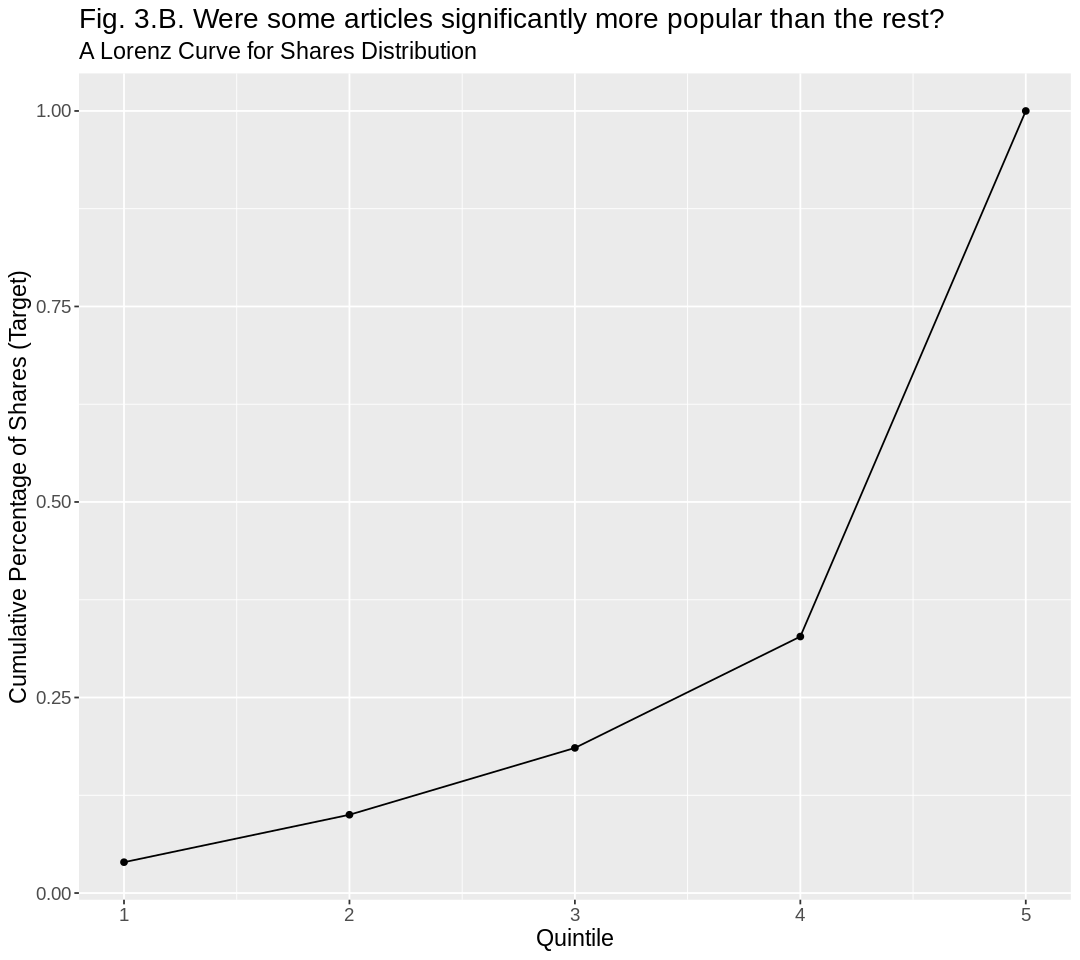

In [6]:
#To illustrate the truly viral nature of SOME of these articles, we will compare the 5 quintiles of shared articles (In our training set)
train_shares_quintiles <- news_train %>%
                   mutate(quintile = ntile(shares, 5)) %>% #assigns each observation to appropriate quintile from 1-5
                   arrange(shares) %>%
                   group_by(quintile) %>%
                   summarise(total_shares_in_quintile = sum(shares)) %>% #find total number of shares within each quintile
                   mutate(cumulative_total_shares = cumsum(total_shares_in_quintile), #comulative sum of shares over quintiles
                          percent_share = total_shares_in_quintile / 100944658, # 100944658 = total sum of shares in training set. percent_share indicates how much of total shares
                                                                                # does each quintile 'capture'?
                          cum_percent_share = cumsum(percent_share)) #cumulative percentage share; must add to 100%.

knitr::kable(train_shares_quintiles, caption = "3.B: Distribution of Shares among quintiles of articles", col.names = c("Quintile", "Total Shares in Quintile",
                                                                                                                       "Cumulative Total Shares", "% of Shares", "Cumulative % of Shares"))

options(repr.plot.height = 8, repr.plot.width = 9)

lorenz_curve <- train_shares_quintiles %>%
                 ggplot(aes(quintile, cum_percent_share)) +
                 geom_point() +
                 geom_line() +
                 labs(x = "Quintile", y = "Cumulative Percentage of Shares (Target)") +
                 ggtitle("Fig. 3.B. Were some articles significantly more popular than the rest?", subtitle = "A Lorenz Curve for Shares Distribution") +
                 theme(text = element_text(size = 14))

lorenz_curve

#### Insights:
- The top 20% of the artilcles captured over 67% of total number of shares in the training dataset!
- Viewed in light of the density distribution of shares (Fig. 3.A), it's obvious that there are significant 'dispartities in outcomes' with regard to the number of shares garnered by articles within eah of the 5 quintiles.

### 4.A. Choosing the appropriate predictors for the Linear Regression model

 We start with 4 features that appeal to our intuition (explained in plot subtitles), and then evaluate how they perform against our expectations. Would our initial choice of features do a reliable job at predicting popularity of future articles? Do they have any correlation with popularity of articles in our training dataset?

Warning message:
“Removed 1 rows containing missing values (geom_point).”
`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



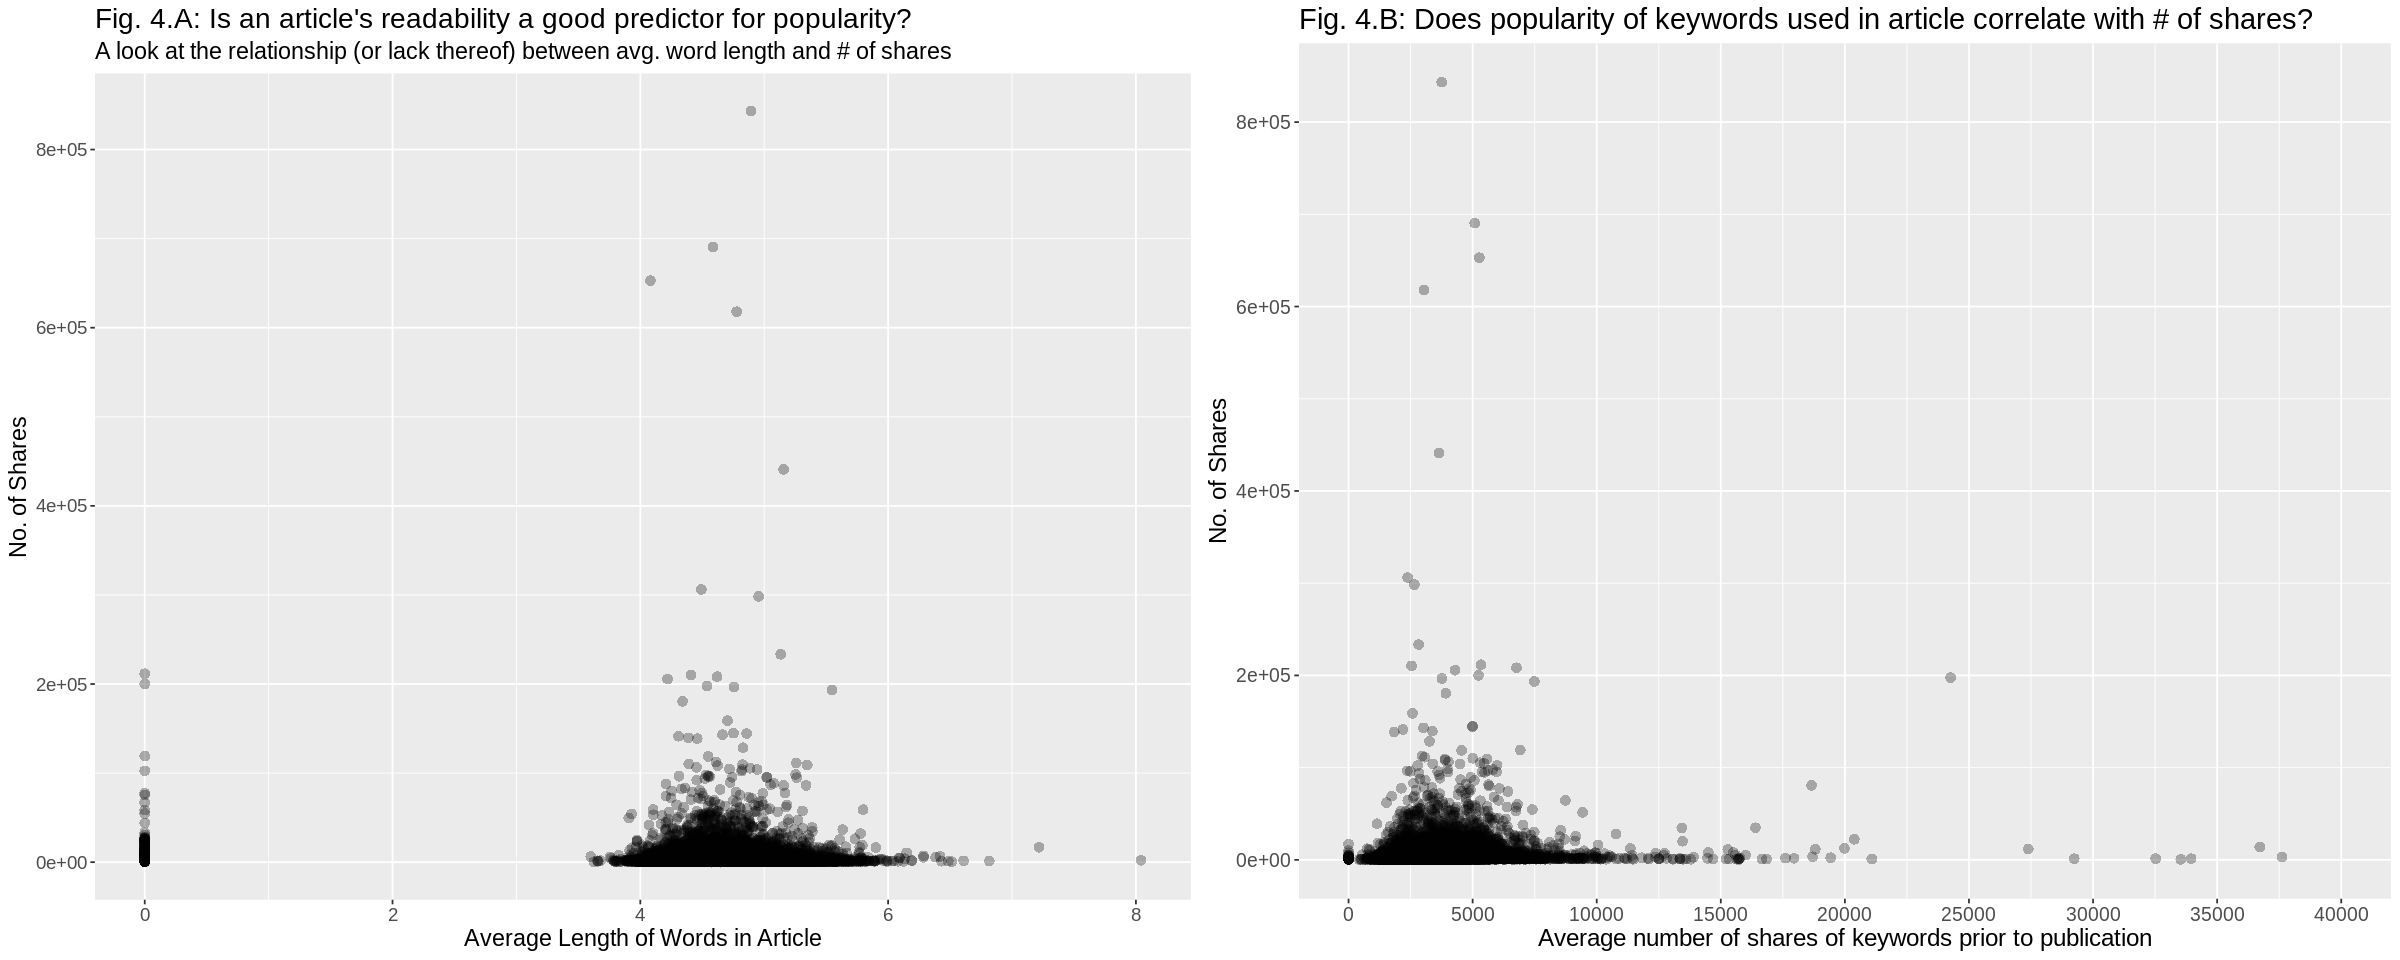

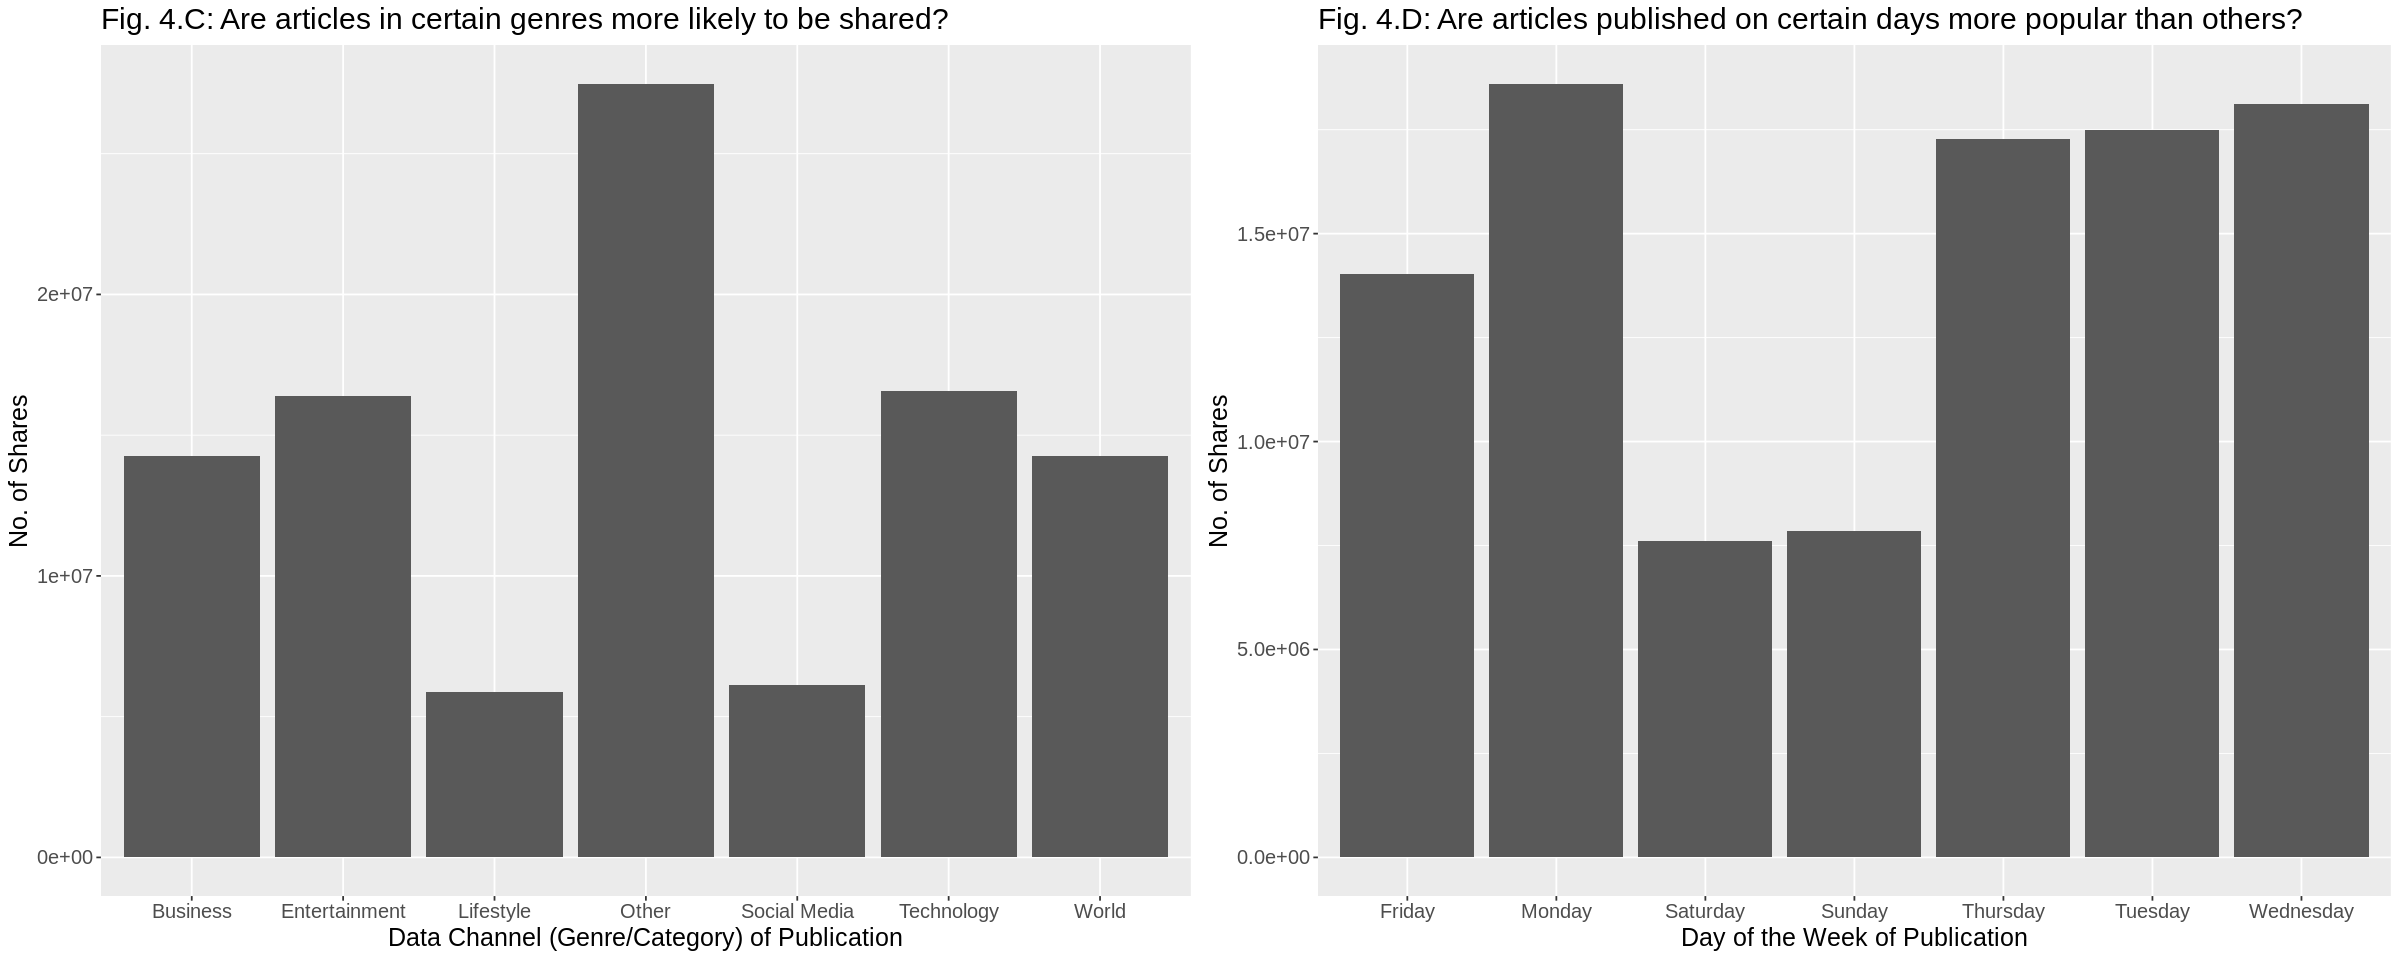

In [7]:
options(repr.plot.height = 8, repr.plot.width = 20)

#Plotting # of shares vs. article's word count.
token_length_plot <- news_train %>%
         ggplot(aes(average_token_length, shares)) +
         geom_point(alpha = 0.30, size = 3, stroke = 0) +
         labs(x = "Average Length of Words in Article", y = "No. of Shares", subtitle = "A look at the relationship (or lack thereof) between avg. word length and # of shares") +
         theme(text = element_text(size = 14)) +
         ggtitle("Fig. 4.A: Is an article's readability a good predictor for popularity?")


#Plotting # of shares vs. avg. number of shares received previously by the average performing keyword in the article (Further explained in the insights section)
keyword_plot <- news_train %>%
         ggplot(aes(kw_avg_avg, shares)) +
         geom_point(alpha = 0.30, size = 3, stroke = 0) +
         labs(x = "Average number of shares of keywords prior to publication", y = "No. of Shares") +
         theme(text = element_text(size = 14.5)) +
         scale_x_continuous(n.breaks = 10, limit = c(0, 40000)) +
         ggtitle("Fig. 4.B: Does popularity of keywords used in article correlate with # of shares?") 

#To nicely arrange our first two plots side-by-side
grid.arrange(token_length_plot, keyword_plot, ncol = 2)  

#Plotting # of shares vs. different data channels ie. categories/genres the Mashable articles were publishd in
channel_plot <- news_train %>%
         group_by(data_channel) %>%
         summarise(tot_shares = sum(shares)) %>%
         ggplot(aes(x = data_channel, y = tot_shares)) +
         geom_bar(stat = 'identity') +
         labs(x = "Data Channel (Genre/Category) of Publication", y = "No. of Shares") +
         theme(text = element_text(size = 15)) +
         ggtitle("Fig. 4.C: Are articles in certain genres more likely to be shared?") 

#Plotting # of shares vs. the day of the week the Mashable articles were published on
day_plot <- news_train %>%
         group_by(day_of_week) %>%
         summarise(tot_shares = sum(shares)) %>%
         ggplot(aes(day_of_week, tot_shares)) +
         geom_bar(stat = "identity") +
         labs(x = "Day of the Week of Publication", y = "No. of Shares") +
         theme(text = element_text(size = 15)) +
         ggtitle("Fig. 4.D: Are articles published on certain days more popular than others?")

grid.arrange(channel_plot, day_plot, ncol = 2)  

### 4.A. Insights from visual EDA:
- **Fig. 4.A** tells us that most often, the average word length within articles published is in the range of 4-6 characters. Those posts which received higher amounts of shares had an average word length of slighly bigger than 4. This is consistent with our initial assumption that shorter average word lengths would make the article more readable to diverse audiences. More importantly, Fig. 4.A shows that as the average word length increases, the number of shares received decreases. This is also consistent with our assumption that longer words on average make the article harder to read, which must affect their popularity amongst audiences. 
- **Fig. 4.B**: In their paper, Fernandes et all (2015). first rank all article keyword average shares (known before publication), in order to get the worst, average and best keywords. For each of these keywords, they then extract the minimum, average and maximum number of shares. The plot suggests that one could gain shares by including keywords which have previously received significant number of shares. In fact, for the majority of popular articles, the average keyword had received on average nearly 4000 shares previously.
- In **Fig. 4.C**, we can see that Mashable articles belonging to 'Other' category were more popular than any other articles published in other categories. Technology and Entertainment came second and third, though the margins between them were almost neglible. We observe that articles in Lifestyle and Social Media section fared poorly than others, which is surprising as we expected these genres to be more likely to be 'viral'. It remains an open question as to what the Other section entails. While we're sure what this section is not (it's not Business or World or any other channel in the plot), we might be interested in exploring which kind of channels might be included in Other channel that have the potential to produce relatively higher proportion of Viral and Popular posts as compared to other channels.
- **Fig. 4.D**. suggests that there isn't as much advantage to gain by publishing on certain days as we might've expected. It's clear that articles published on Saturday and Sunday fared significantly poorly, despite it being an off-day from work for many people. Monday fared the best, though only by negligible margins when compared to Thursday, Tuesday or Wednesday.

#### However, we'd like to further evaluate which features are appropriate as predictors by running a Pearson Correlation-Coefficient Matrix. So far, we've discussed the following: 
- `average_token_length`: average length of words in the artice (Fig 4.A)
- `kw_avg_avg`: Average number of shares of keywords prior to publication (Fig. 4.B)
- `data_channel`: The category/genre article was published in (Fig. 4.C)
- `day_of_week`: Day of Week on which article was published (Fig. 4.D). **We've decided to drop this feature, as we've explained how it doesn't seem to have a large discriminatory effect on popularity.**

#### In addition to these features, we'll also check the following features for any strong correlations with our target variable:
- `num_images`: number of images in the article. We assume/hypothesize that higher graphical content makes an article more appealing to certain audiences, improving visual attention (cite)and therefore chances of popularity. 
- `global_subjectivity`: Our project proposal demonstrated that the most successful articles were only mildly subjective (in the 0.40 to 0.60 range, ie. in the range where the absolute difference of subjectivity score from 0.50 is between 0.40 and 0.60). The Pearson correlation matrix, would give us both visual and quantitative insights about any correlation with # of shares.<i> Note: Subjective sentences are those with opinion, emotion, and judgement, in contrast with objective sentences that are made up of factual information. Subjectivity is a float which lies in the range of [0,1], and in this case global subjectivity measures subjectivity of the entire article </i> (Jain 2018).

- `LDA_##`: How close is the article to any of the top 5 LDA topics? LDA is a popular technique used in topic modeling to classify documents without supervision on the basis of common occuring patterns in the words. In our context, the original contributors behind the dataset used topic modeling to find recurring groups of items (topics), and then used the article's textual content to determine how closely related it is to each of the top 5 topics (Blei et al. 2003). We wish to see if any of the top 5 articles are more correlated with popularity (# of shares)?
- `Self_reference_avg_sharess`: the average number of shares received by other Mashable articles linked (referenced) in the article? Is a newly published article more likely to be popular if it references (contains links) to older, popular articles? While this seems untuititive at first glance, it might be the case that different page ranking algorithms implemented by Google, Facebook etc. favour artiles with backlinks to higher ranked articles.


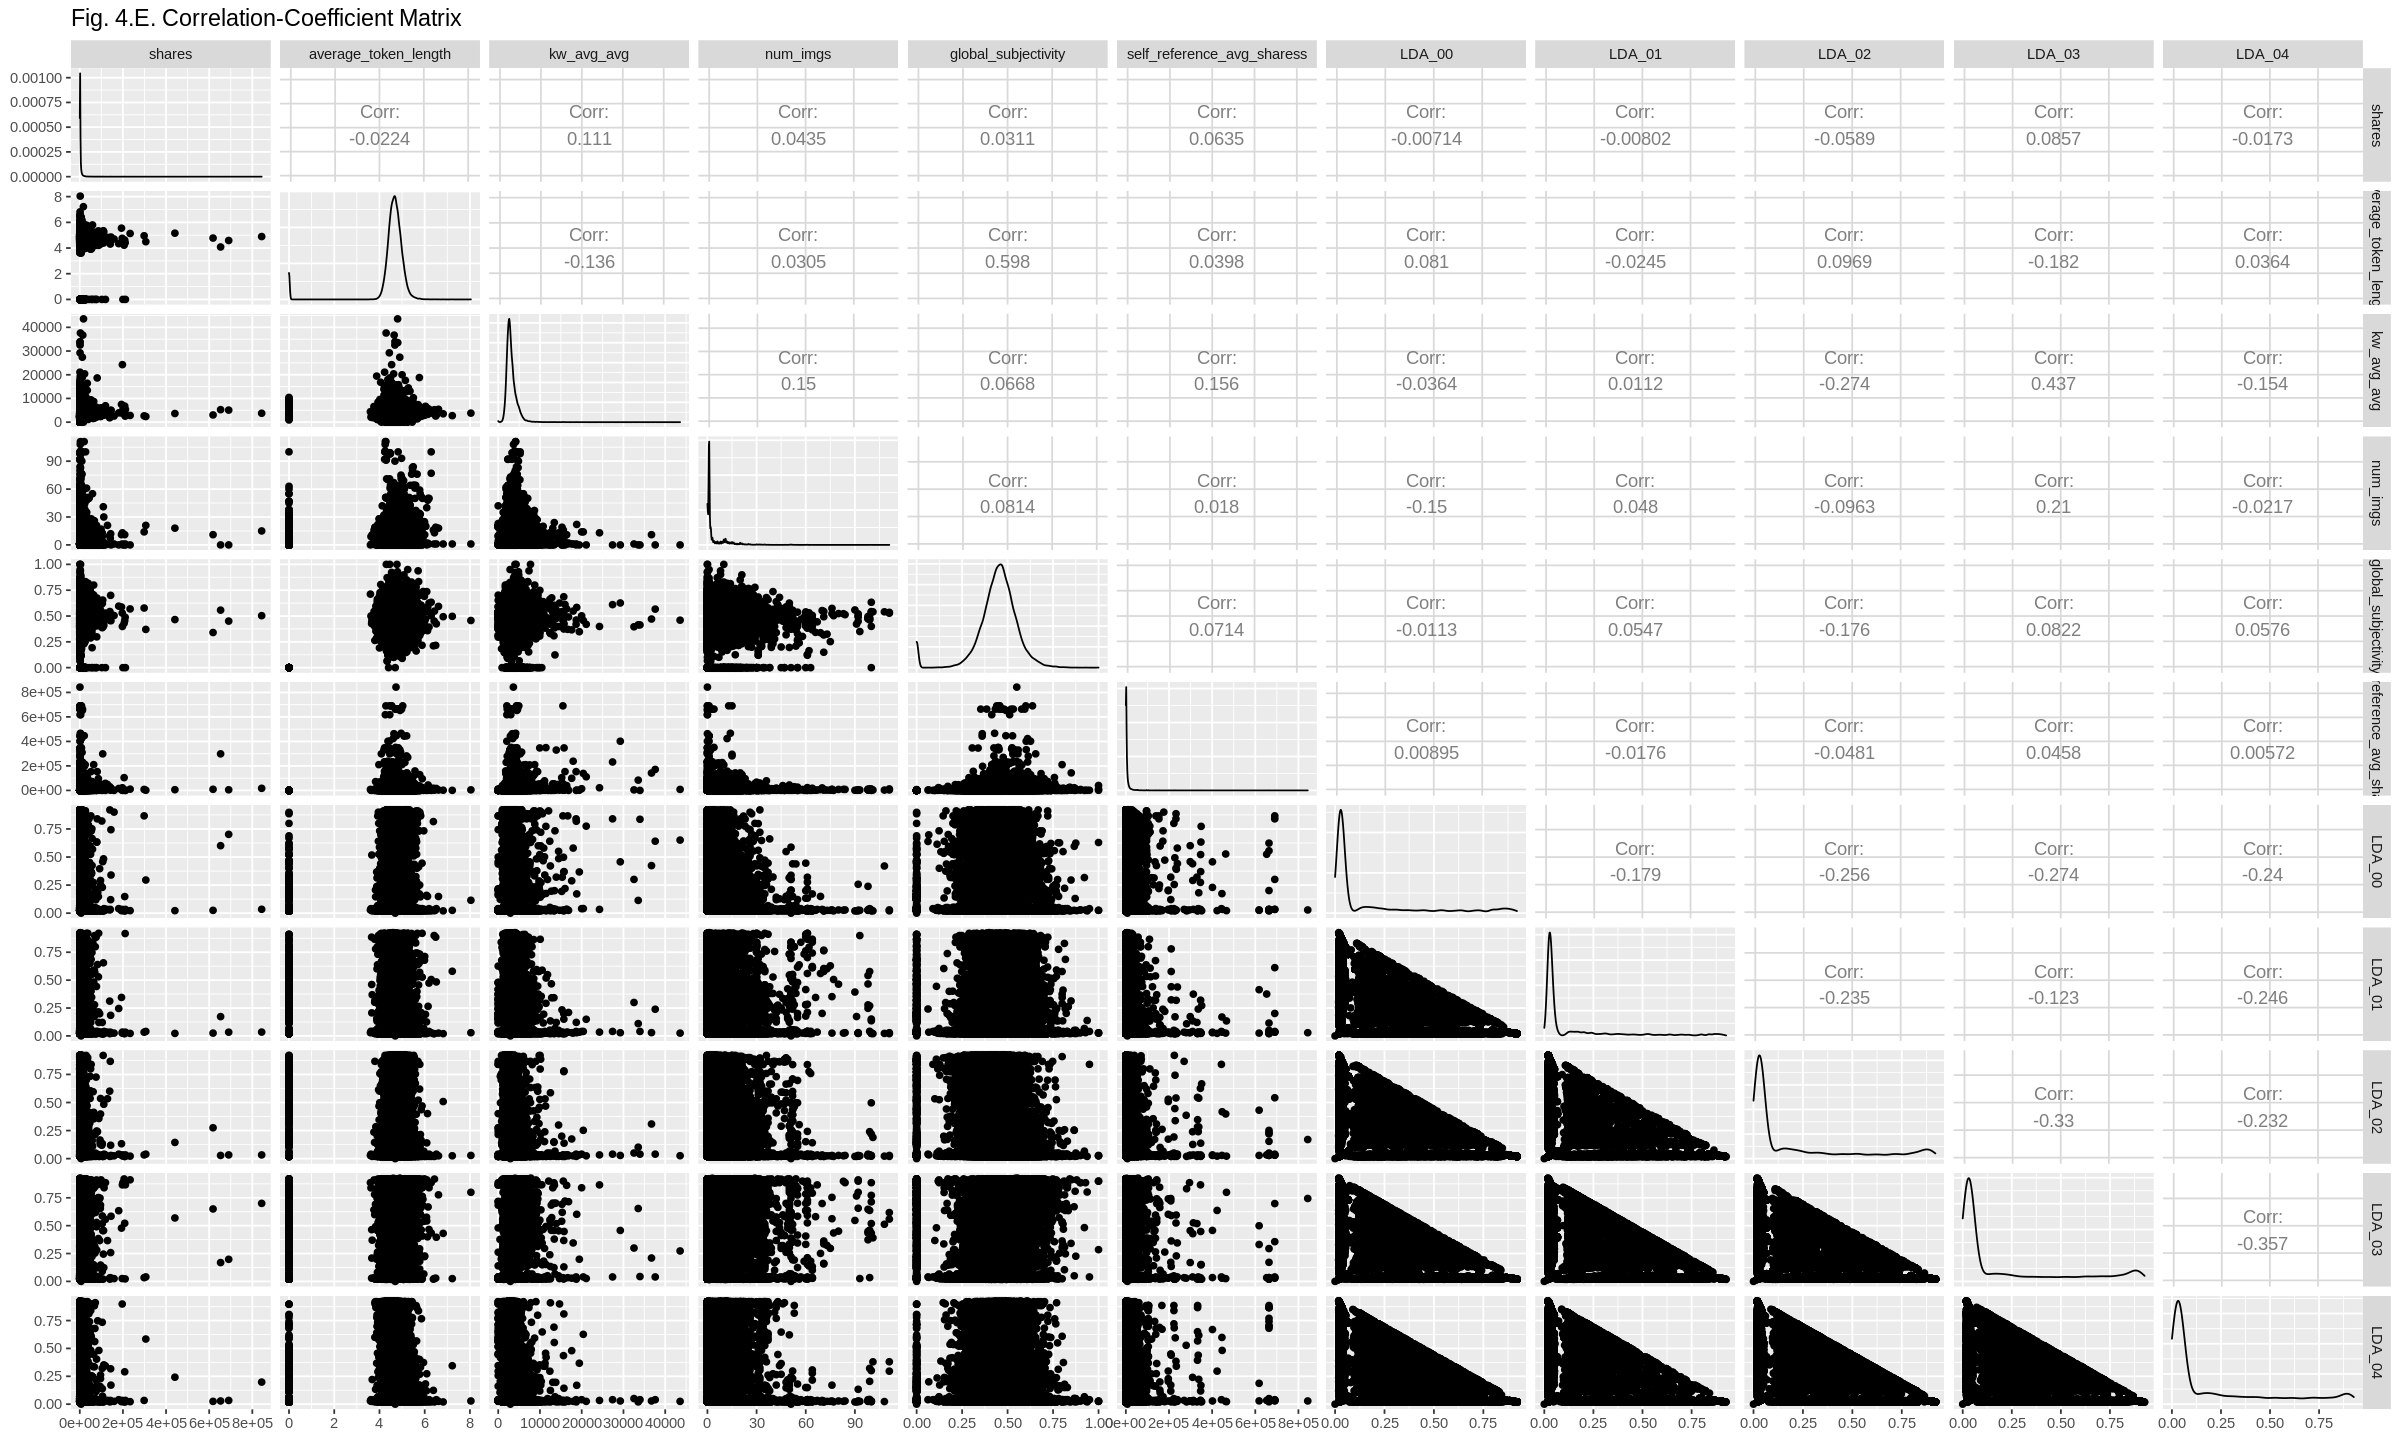

In [8]:
## More reliable way: correlation-coefficient matrix
options(repr.plot.height = 12, repr.plot.width = 20)
correl_mat <- news_train %>%
              select(shares,average_token_length, kw_avg_avg, num_imgs, global_subjectivity, self_reference_avg_sharess, LDA_00, LDA_01, LDA_02, LDA_03, LDA_04) %>%
              ggpairs() +
              ggtitle("Fig. 4.E. Correlation-Coefficient Matrix") +
              theme(plot.title = element_text(size = 14))

correl_mat

### 4.B. Insights from Pearson Coefficients and Correlation Matrix:
All of the features offer fairly small correlations with the number of shares. However, some of our choices stand out:
1. `kw_avg_avg` has the highest correlation coefficient of all the features chosen. We're also encouraged by the fact that Fernandes et all (2015), in their paper, using the Random Forest model, determined kw_avg_avg as the most important feature in the dataset (cite). Recall, `kw_avg_avg` is an indicator of how many shares on average did the averagely popular keyword in our article receive previously.
2. `LDA_03` has the second highest correlation coefficient. This implies that any article that's closer to LDA Topic 3 in its content is more likely to be popular. Unfortunately, we've been unable to determine what does the LDA Topic 03 entail because neither the original dataset nor Fernandes et al.'s article offers any explaination behind what words make up the topic 03. It's interesting to observe that LDA_03 is significantly popular than other LDA topics, all of which have negative coefficients!
3. `self_reference_avg_sharess` has the third largest coefficient (among our choices). This implies that the popularity of old articles referenced in a new article (measured via average shares received) plays an important role in determing the popularity of the new topic. 
4. `global_subjectivity`'s and `num_imgs`'s coefficients are still small comapared to others and this suggests that article's text subjectivity or the number of images doesn't have as important role to play in determining popularity. This is also consistent with what we found in our group proposal's EDAs: the highly popular articles were only mildly subjective and only contained less than 5 images with no discernible pattern between the variable and shares. **We therefore drop these two features from consideration in favour of more important features.**
5. `average_token_length` is unique as its correlation coefficient is negative. This does stay consistent with our assumptions stated before (an idea that longer words mean less readability which means less popular). **But the magnitude of coefficient is fairly small and we decide to drop it, suspecting that it doesn't have as much as an impact on # shares compared to other predictors in the matrix.**
6. While not included in the matrix above, **Fig. 4.C** speaks to the discriminatory impact `data_channel`, ie. genre/category of article, has on its popularity (within training set). Fernandes et all (2015)'s results from Random Forest model suggest that data_channel one of the top 4 most important features (cite). Given both pieces of information, we'll go ahead with data_channel as one of our predictors.

To reiterare, our final choice of predicors: `kw_avg_avg`,`LDA_03`,`self_reference_avg_sharess`,`data_channel`,

## 5. Creating our recipe, model, fitting the train data and predicting on test data

In [9]:
news_recipe <- recipe(shares ~ kw_avg_avg + LDA_03 + self_reference_avg_sharess + data_channel, data = news_train) %>%
               step_dummy(data_channel)

news_spec <- linear_reg() %>%
			set_engine("lm") %>%
			set_mode("regression")

news_fit <- workflow() %>%
            add_recipe(news_recipe) %>%
            add_model(news_spec) %>%
            fit(news_train)

news_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

● step_dummy()

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
               (Intercept)                  kw_avg_avg  
                 938.42870                     0.63900  
                    LDA_03  self_reference_avg_sharess  
                1061.39655                     0.02283  
data_channel_Entertainment      data_channel_Lifestyle  
                -359.65643                   277.35454  
        data_channel_Other   data_channel_Social.Media  
                1230.12970                   135.16603  
   data_channel_Technology          data_channel_World  
                 102.33410                  -476.88942  


### 5.A. Insights from Workflow/Fit output:

Given the ease of interpreting an output for linear regression, we can build a linear equation as follows:

$Number\: of \: Shares = 938.42870 + 1061.39655 * closeness\: to\: top\: 3\: LDA\: topics -359.65643 * category\: is\: entertainment + 1230.1297 * category\: is\: Other + 102.33410 * category\: is\: technology\: + 0.63900 * avg.\: shares\: of\: avg.\: keyword + 0.02283 * avg.\: shares\: of \: referenced\: articles + 277.35454 * category\: is\: entertainment + 135.16603 * category\: is\: Social\: Media - 476.88943 * category\: is\: World$

All variables corresponding to `data_channel` (eg. Category is Social Media etc.) can only take a value of either 1 or 0. 
We will further reflect on some of these coefficients in section 6.

### 5.B. How does our model perform on testing data?

In [10]:
# LET'S SEE HOW IT PERFORMS ON UNSEEN TESTING DATA:
news_results <- news_fit %>%
                predict(news_test) %>%
                bind_cols(news_test) %>%
                metrics(truth = shares, estimate = .pred) %>%
                filter(.metric == "rmse") %>%
			    select(.estimate) %>%
			    pull()
knitr::kable(news_results, caption = "5.A: RMSPE for Linear Regression Model", col.names = c("RMSPE"))

# TO INTERPRET OUR RMSPE, PERHAPS HAVE A LOOK AT THE STANDARD DEVIATION OF TEST DATA
shares_info2 <- news_test %>%
               summarise(max_shares = max(shares),
                        median_shares = median(shares),
                        min_shares = min(shares),
                        sd_shares = sd(shares))
knitr::kable(shares_info2, caption = "5.B: Quantitative Summary for `shares` in Test Data", col.names = c("Maximum", "Median", "Minimum", "Standard Deviation"))



Table: 5.A: RMSPE for Linear Regression Model

|    RMSPE|
|--------:|
| 10978.72|



Table: 5.B: Quantitative Summary for `shares` in Test Data

| Maximum| Median| Minimum| Standard Deviation|
|-------:|------:|-------:|------------------:|
|  663600|   1400|       4|           11060.59|

1. RMPSE (Mean Prediction Standard Error) is 10978.72, which is a bit less than the standard deviation of # of shares in testing data. While standard deviation tells us target variable observations in testing data vary around the mean, our `rmspe` tells us how much more variation away from the mean our model explains.
2. Even if we add the dropped choices - num_imgs, global_subjectivity and average_token_length - we only achieve an improvement of 0.03% (code not shown to maintain brevity of the report)

In [20]:
# LET'S COMPARE WITH WHAT RMSPE WE GET WITH KNN-REGRESSION.

#Creating the recipe with chosen predictors
knn_recipe <- recipe(shares ~ kw_avg_avg + LDA_03 + self_reference_avg_sharess + average_token_length + data_channel, data = news_train) %>%
  step_dummy(data_channel) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

#Creating a tuned nearest neighbour model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

#Given the constraints on computing time and the large size of our dataset, we'll evaluate uptill 10 neighbours
gridvals <- tibble(neighbors = seq(1, 10))

#Choosing 5, a typical choice, for the number of cross validation folds
knn_vfold <- vfold_cv(news_train, v = 5, strata = shares)

news_k <- workflow() %>%
  add_recipe(knn_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(knn_vfold, grid = gridvals) %>%
  collect_metrics() %>%
  filter(.metric == "rmse") %>%
  filter(mean == min(mean)) %>%
  pull(neighbors)

news_k

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = news_k) %>%
  set_engine("kknn") %>%
  set_mode("regression")

knn_mult_fit <- workflow() %>%
  add_recipe(knn_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = news_train)

knn_mult_preds <- knn_mult_fit %>%
  predict(news_test) %>%
  bind_cols(news_test)

knn_mult_mets <- metrics(knn_mult_preds, truth = shares, estimate = .pred) %>%
                 filter(.metric == "rmse") %>%
                 select(.estimate) %>%
                 pull()

knitr::kable(knn_mult_mets, caption = "5.C: RMSPE for KNN-Regression (K = 10)", col.names = "RMSPE")

[1] 10



Table: 5.C: RMSPE for KNN-Regression (K = 10)

|    RMSPE|
|--------:|
| 11732.14|

The RMSPE for our KNN-Regression model is 11732.1413539335 which is about 6.8% larger than the RMSPE for our Linear Regression Model. However, this must be taken with salt: given constraints on server's computation time, we were forced to limit our choice of K till 10 such that the cross-validation runs within a sensible runtime. It could be the case that using K = 10 underfits the training data, and there might be gains to be made with KNN-Regression as well. However, after cross-validating against a choice uptill K = 40 (and after waiting for a really long time), we found that RMSPE decreased by about only 100. 

## 6. Conclusion

Let's again consider our research question: Can a linear regression model reliably predict the popularity of an article given some knowledge about some of its features?

We argue that a holistic response to this questions needs to discuss the interpretability of our RMSPE, linear regression equation and a few 'hidden' pieces of information about some of our top performing predictors (eg. `LDA_03` etc.). We try to summarise and evaluate our results and lay ground for further open-ended questions as following:

### 6.A. Results (Interpreting RMSPE)
- The RMSPE calculated for our Linear Regression model is 10978.7191597422 which is within the standard deviations of target variable in the training and whole datasets. The RMSPE for our model is also smaller than the RMSPE for an alterate KNN-Regression Model.
- Moroeover, we prefer our Linear Regression model as it offers an intuitive way to model the prediction using a linear equation (obtained in previous sections). Unfortunately, we don't have the skills required to visualize our predicted values against5 actual values because the number of predictors is well more than 2. We're assuming that we'd need a 3D visualization for that purpose.
- Adding the dropped choices for predictors to our model only increased the RMSPE by 0.03%. After referring to Fernandes et al.'s list of predictors ranked in order of importance (2015), we're confident that our model is already using the reasonably impactful predictors.
- It can always be the case that this problem could not be reasonably modelled by a linear relationship (eg. what if it's curved, exponential etc?). We also acknowledge that there are other models such as the Random Forest Generator which are beyond the scope of this class but are offer significantly more accurate predictions (Fernandes et al. 2015).
- **Lastly, we must also question what our RMSPE might mean to a writer or a news publication. Consider the case that an article which was predicted to receive 20,000 shares only receives 8,000 shares. That must be of concern to the editors, advertisors and other stakeholders. But what if an article predicted to receive 45,000 shares, receives 43,500 shares? Of course, the opinions of stakeholders vary according to the context.**

### 6.B. <i> Few Unexpected Coefficients (eg. the case of `data_channel`) </i>

We constructed a linear equation using the coefficients from the Workflow/Fit output:

$Number\: of \: Shares = 938.42870 + 1061.39655 * closeness\: to\: top\: 3\: LDA\: topics -359.65643 * category\: is\: entertainment + 1230.1297 * category\: is\: Other + 102.33410 * category\: is\: technology\: + 0.63900 * avg.\: shares\: of\: avg.\: keyword + 0.02283 * avg.\: shares\: of \: referenced\: articles + 277.35454 * category\: is\: entertainment + 135.16603 * category\: is\: Social\: Media - 476.88943 * category\: is\: World$

- It's surprising that `LDA_03` has a higher coefficient compared to `kw_avg_avg`, despite the fact that `kw_avg_avg` had the highest Pearson coefficient amongst all others.  
- Also surprising how Lifestyle's coefficient is positive while for World category, it's negative. This isn't consistent with Fig. 4.C. Perhaps we should also be looking at how many articles were published in each category instead of just the distribution of shares.

`summarise()` ungrouping output (override with `.groups` argument)



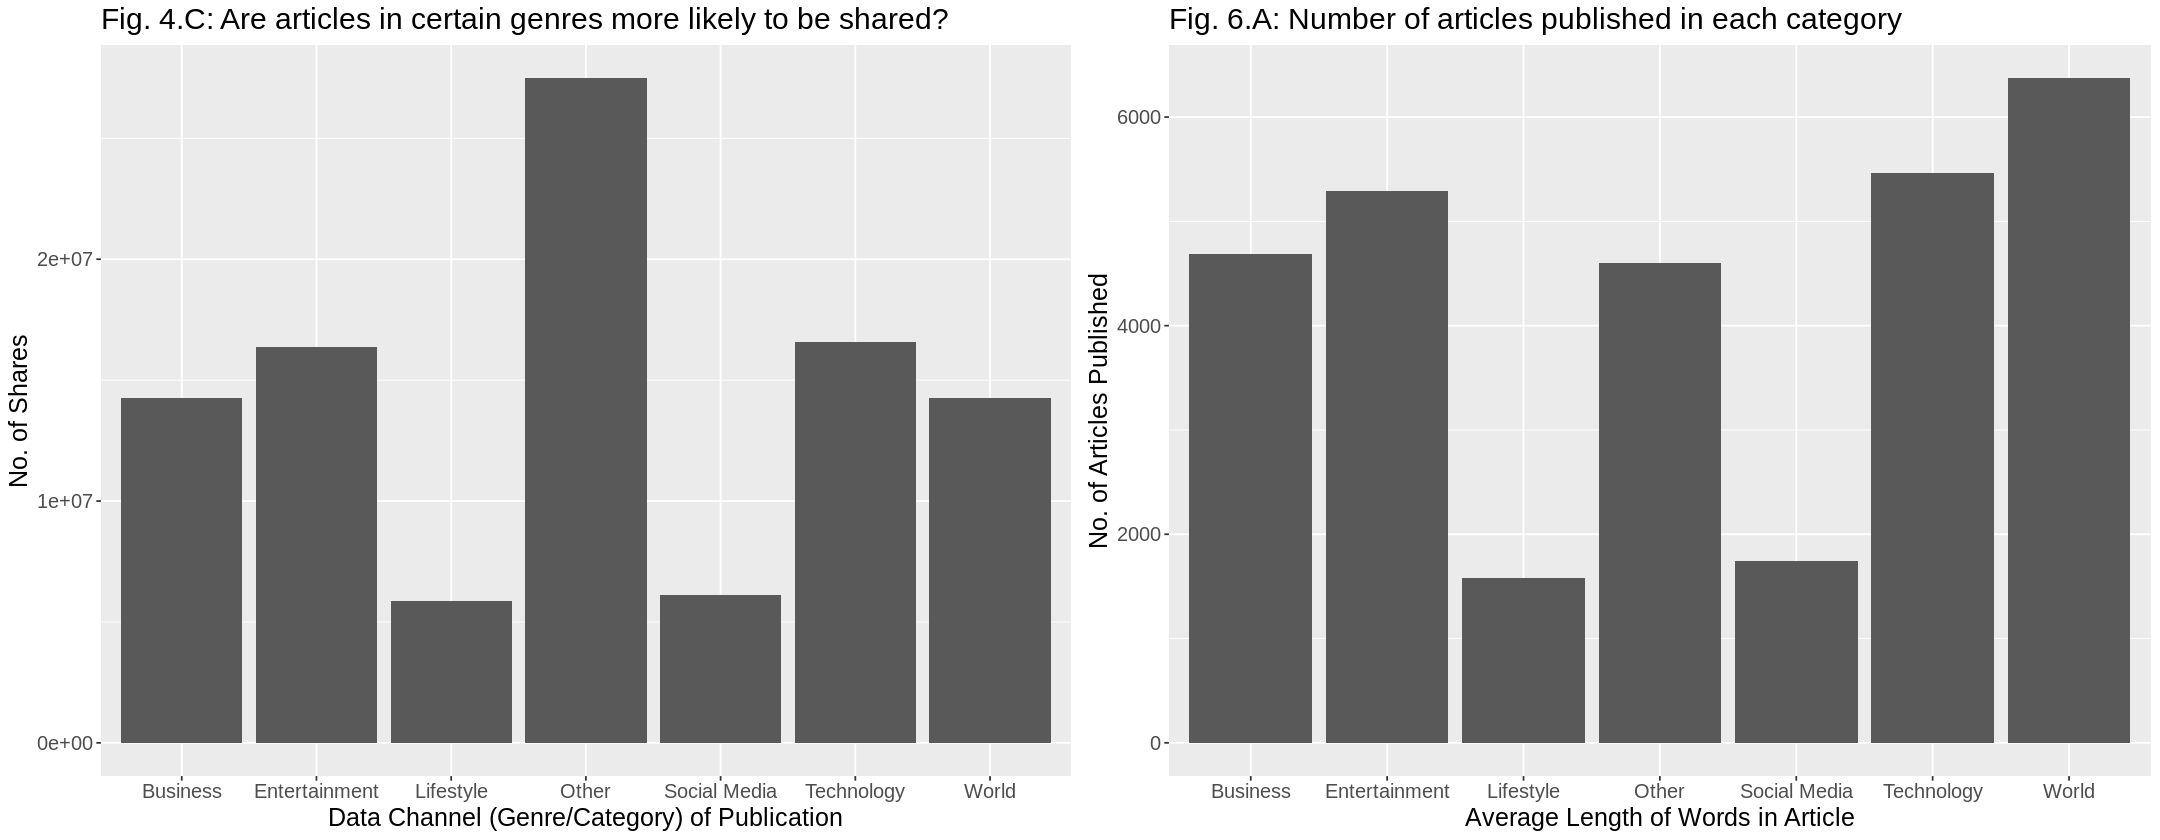

In [21]:
# Revisiting our assumptions about which data channels are better performing and why the coefficients for data channels do not match our expectations.
options(repr.plot.height = 7, repr.plot.width = 18)

channel_publications <- news_train %>%
         group_by(data_channel) %>%
         summarise(count = n()) %>%
         ggplot(aes(x = data_channel, y = count)) +
         geom_bar(stat = 'identity') +
         labs(x = "Average Length of Words in Article", y = "No. of Articles Published") +
         theme(text = element_text(size = 15)) +
         ggtitle("Fig. 6.A: Number of articles published in each category") +
         scale_fill_brewer(palette = "Set3")

grid.arrange(channel_plot, channel_publications, ncol = 2)  

- This does clear a few doubts: The World category/data channel doesn't seem as popular now, given the relatively high number of articles published and most of which fared poorly. Same is the case for Entertainment which explains why our model assigned World and Entertainment with big negative coefficients.

- The reason behind the model assigning Lifestyle a larger than expected coefficient could be the fact that very little articles are published in Lifestyle category in the first place. We initially (eg. in our project proposal) had dismissed this category as highly unpopular. However, it might be the case that Lifestyle section has a lower proportion of underperforming articles as compared to the World or Entertainment categories.

### 6.C. <i> What's the `Other` channel? </i> 
- The concentration of viral articles in the “other” channel was not expected. The Pearson coefficients and our linear regression equation both suggest that `Other` section's artice are more likely to viral. We believe that articles in this section could be hybrid articles that fit into multiple channels, and as such are not classified into either channel, but still get shares from the audiences of both channels. This is a possible explanation for why articles in the “other” channel were shared the most. Alternatively, it is possible that not all of the articles published on Mashable are given a channel and as such some that fit into channels like business and entertainment end up in the “other” category. 

### 6.D. <i> Is there a way to determine which kind of content `LDA_03` (Latent Dirichlet Allocation Topic 03) corresponds to? </i>

We found that the drawback of unsupervised latent dirichlet allocation is that while it organizes words by topic, it does not output the meaning of the topics. This inhibits our analysis of LDA_03, which is a unique topic in this context as it is the only one of five LDA topics to have a positive correlation coefficient. The importance of this predictor is emphasized by the fact it has the second highest pearson correlation coefficient of the predictors included in the correlation coefficient. While the unsupervised LDA method prevents us from knowing exactly what the topic is, we infer that topic three includes words that are more common in interdisciplinary settings than the other four topics, as these words will be found in articles that attract readers with interests in multiple disciplines resulting in more overall shares. 

### 6.E. <i> Significance of the Report and Closing Remarks
Any conclusive findings from our project would be significant for spheres of journalism and blogging alike. To evaluate the impact of negative polarized sentiment on popularity is to put in perspective the mainstream media’s “outrage sells” strategy. Additionally, authors might prefer to prioritize quality over quantity and only publish on the better-performing days of the week. Some authors may shift between publication channels, eg from low engagement segments to more popular ones.
    
Some additional questions beyond the scope of this project: What are the data channels that make up the Other category? For instance, does it include niche topics such as Sport which are cannot be categorized in the existing group of categories? Or do they include content that contains a mixture of two or more categories and hence is categorized under “Other”? Are the shorter average word lengths a result of the article’s data channel i.e. would our model be still as accurate with one of these two predictors removed?

As students of DSCI 100, we aim to carry forward the insights and lessons learned from this project in order to further explore the aforementioned unanswered questions in our free time or future Data Science courses/projects. An exciting step in this direction would be to learn the Random Forest Generator models as RF model achieved an accuracy of 73% with the dataset (Fernandes et al. 2015). We'll also like to learn more about LDA Topics and if there are industry standard methods of determining what a certain LDA Topic comprises of.

## 7. Works Cited

David M. Blei, Andrew Y. Ng, and Michael I. Jordan. 2003. Latent Dirichlet allocation. Journal of Machine Learning Research 3 (Jan. 2003), 993--1022.

K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.

Jain, S. (2020, December 23). Natural Language Processing for Beginners: Using TextBlob. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/#:%7E:text=Subjective%20sentences%20generally%20refer%20to,objective%20refers%20to%20factual%20information.&text=We%20can%20see%20that%20polarity,and%20not%20a%20factual%20information.